# **1. Import Dependencies**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import dijkstra
import networkx as nx

In [ ]:
from matplotlib.collections import LineCollection

# **2. Testing Grounds**

In [ ]:
CANVAS_SIZE = 1000
NUM_STATIONS = 20
ISLAND_PENALTY = 5000

In [ ]:
CANVAS = tf.fill((CANVAS_SIZE, CANVAS_SIZE), 0).numpy()

In [ ]:
STATION_IDXS = tf.random.uniform(
    shape=(NUM_STATIONS, 2),
    minval=0,
    maxval=CANVAS_SIZE-1,
    dtype=tf.int32
).numpy()

STATION_IDXS

array([[149, 481],
       [170, 215],
       [739, 490],
       [621, 337],
       [208, 418],
       [711, 920],
       [238, 387],
       [323, 675],
       [994, 630],
       [332, 723],
       [ 91,  38],
       [554, 671],
       [919, 309],
       [910, 603],
       [119, 452],
       [806, 197],
       [ 58, 351],
       [ 99, 142],
       [415, 313],
       [ 43,   7]], dtype=int32)

In [ ]:
STATION_SIZES = tf.random.normal(
    shape=(NUM_STATIONS,),
    mean=500.0,
    stddev=200.0,
    dtype=tf.float32
).numpy()

STATION_SIZES

array([707.4353 , 474.68546, 187.8266 , 579.98816, 353.2962 , 800.453  ,
       802.75854, 468.9419 , 327.56213, 496.77017, 533.274  , 562.5706 ,
       564.15784, 249.82275, 718.1693 , 330.55917, 220.68924, 292.3385 ,
       424.1521 , 286.61304], dtype=float32)

In [ ]:
DISTANCES = np.zeros((NUM_STATIONS, NUM_STATIONS))

for i in range(NUM_STATIONS):
  for j in range(NUM_STATIONS):
    DISTANCES[i,j] = np.linalg.norm(STATION_IDXS[i]-STATION_IDXS[j])

DISTANCES

array([[   0.        ,  266.82765974,  590.06864008,  493.47745643,
          86.31338251,  713.13743416,  129.44883159,  260.59930929,
         858.03612978,  303.4023731 ,  446.78070684,  447.35332792,
         788.97655225,  770.71719846,   41.72529209,  715.7548463 ,
         158.685223  ,  342.6674773 ,  314.61087076,  485.70773105],
       [ 266.82765974,    0.        ,  631.96993599,  467.20980298,
         206.52602742,  888.65403842,  184.95404835,  484.77726844,
         922.60554952,  533.20540132,  193.82982227,  596.14763272,
         754.87548642,  835.55011819,  242.42524621,  636.25466599,
         176.18172436,  101.83319694,  263.87307555,  243.70679104],
       [ 590.06864008,  631.96993599,    0.        ,  193.21749403,
         535.85912328,  430.9106636 ,  511.47824978,  455.28123177,
         290.90376416,  468.9754791 ,  790.06835147,  258.81653734,
         255.26652738,  204.96341137,  621.16342455,  300.56280542,
         695.04100598,  728.49433766,  369.195

In [ ]:
DEMAND = tf.random.uniform(
    shape=(NUM_STATIONS, NUM_STATIONS),
    minval=0,
    maxval=1
).numpy()

# Scale based on inverse root of distance
for i in range(NUM_STATIONS):
  for j in range(NUM_STATIONS):
    if i != j:
      DEMAND[i,j] *= (1 / (DISTANCES[i,j]**0.5))
    else:
      DEMAND[i,j] = 0

# Standardize
for col in range(NUM_STATIONS):
  colSum = np.sum(DEMAND[:, col])
  for row in range(NUM_STATIONS):
    DEMAND[row, col] = DEMAND[row, col] / colSum

DEMAND

array([[0.00000000e+00, 2.31235232e-02, 6.05638400e-02, 6.99432194e-02,
        3.11599337e-02, 2.38037985e-02, 4.37036157e-02, 9.36774835e-02,
        4.61389236e-02, 9.83383060e-02, 3.00903879e-02, 7.01913834e-02,
        8.02320912e-02, 9.58743040e-03, 4.45039906e-02, 6.55670688e-02,
        4.85538654e-02, 5.22005297e-02, 1.14284523e-01, 4.23530675e-02],
       [7.60319754e-02, 0.00000000e+00, 1.98984519e-02, 5.15305959e-02,
        7.80564025e-02, 7.44340420e-02, 9.18277279e-02, 8.51336867e-02,
        7.46369883e-02, 7.26774633e-02, 1.11970738e-01, 4.46901582e-02,
        3.97604331e-02, 4.68072034e-02, 2.33895052e-02, 3.00161652e-02,
        1.56739026e-01, 9.91459787e-02, 7.48747680e-03, 2.60318667e-02],
       [2.25475207e-02, 3.73997055e-02, 0.00000000e+00, 1.05137728e-01,
        3.83432992e-02, 2.21082531e-02, 2.49488242e-02, 1.28705343e-02,
        1.00433361e-02, 8.09605643e-02, 2.79670418e-03, 4.07578275e-02,
        6.70194998e-02, 4.26365063e-02, 1.20665235e-02, 4.0233

In [ ]:
TRIPS = np.array([[int(round(STATION_SIZES[start] * DEMAND[end, start])) for start in range(NUM_STATIONS)] for end in range(NUM_STATIONS)])

TRIPS

array([[  0,  11,  11,  41,  11,  19,  35,  44,  15,  49,  16,  39,  45,
          2,  32,  22,  11,  15,  48,  12],
       [ 54,   0,   4,  30,  28,  60,  74,  40,  24,  36,  60,  25,  22,
         12,  17,  10,  35,  29,   3,   7],
       [ 16,  18,   0,  61,  14,  18,  20,   6,   3,  40,   1,  23,  38,
         11,   9,  13,  20,  13,   6,  10],
       [ 15,  29,  25,   0,  25,  18,  29,  17,  24,  11,  28,  35,  67,
         15,  10,  44,   4,   0,  31,  20],
       [ 30,  27,   3,  20,   0,  49,  26,  53,  20,  26,   8,  31,  33,
         22, 165,  20,   2,  10,  17,  22],
       [  8,  22,  11,  19,   6,   0,   9,  27,   3,  13,   1,  27,  18,
          4,  33,  11,   1,   8,  17,   2],
       [ 70,  48,   5,  13,  79,  81,   0,  22,  11,  40,   4,  41,  61,
         19,   0,  27,  25,   4,  35,  22],
       [ 33,  27,  13,  20,  12,  16,  29,   0,   8, 131,   9,  68,  48,
         21,  10,   3,  24,  14,  36,  20],
       [  3,   3,   4,  28,   9,  81,  24,   4,   0,  32,  23,  

In [ ]:
FLOW = np.zeros((NUM_STATIONS, NUM_STATIONS), dtype=np.int32)

FLOW = TRIPS + TRIPS.T

for i in range(NUM_STATIONS):
  FLOW[i, i] = 0

FLOW

array([[  0,  65,  27,  56,  41,  27, 105,  77,  18,  97,  48,  86,  77,
         17, 123,  50,  36,  91,  93,  53],
       [ 65,   0,  22,  59,  55,  82, 122,  67,  27,  50, 100,  31,  42,
         27,  60,  27,  87,  89,  17,  18],
       [ 27,  22,   0,  86,  17,  29,  25,  19,   7,  49,  12,  25,  60,
         28,  21,  17,  25,  25,   9,  24],
       [ 56,  59,  86,   0,  45,  37,  42,  37,  52,  30,  77,  99, 121,
         23,  56,  75,  16,  20,  55,  41],
       [ 41,  55,  17,  45,   0,  55, 105,  65,  29,  50,  17,  32,  46,
         30, 204,  25,   4,  23,  45,  48],
       [ 27,  82,  29,  37,  55,   0,  90,  43,  84,  45,  21,  55,  57,
         87, 113,  62,  24,  24,  50,  56],
       [105, 122,  25,  42, 105,  90,   0,  51,  35, 103,  50,  80, 100,
         64,  84,  74, 105,  58,  88,  27],
       [ 77,  67,  19,  37,  65,  43,  51,   0,  12, 188,  32, 122,  67,
         30,  46,   5,  45,  22,  55,  29],
       [ 18,  27,   7,  52,  29,  84,  35,  12,   0,  61,  29,  

In [ ]:
FULL_TRACK = 0
for i in range(NUM_STATIONS):
  for j in range(i, NUM_STATIONS):
    FULL_TRACK += DISTANCES[i,j]

FULL_TRACK

97084.48754804156

In [ ]:
"""LINES = np.round(0.7 * np.random.rand(NUM_STATIONS, NUM_STATIONS))

LINES"""

'LINES = np.round(0.7 * np.random.rand(NUM_STATIONS, NUM_STATIONS))\n\nLINES'

In [ ]:
LINES = np.ones((NUM_STATIONS, NUM_STATIONS))

LINES

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.

In [ ]:
def plot_system(CANVAS, LINES, draw_lines=True):
  # Draw canvas
  plt.imshow(CANVAS, cmap='Greys')

  # Draw flow/demand between stations
  demand_lines = []
  for i in range(NUM_STATIONS):
      for j in range(i + 1, NUM_STATIONS):
          demand_lines.append([(STATION_IDXS[i, 0], STATION_IDXS[i, 1]), (STATION_IDXS[j, 0], STATION_IDXS[j, 1])])
  lc_stations = LineCollection(demand_lines, alpha=0.5, linestyle='-', linewidths=TRIPS.flatten()/25)
  plt.gca().add_collection(lc_stations)

  # Draw metro lines between stations
  if draw_lines:
    station_lines = []
    for i in range(NUM_STATIONS):
        for j in range(NUM_STATIONS):
            if LINES[i,j] == 1.0:
                station_lines.append([(STATION_IDXS[i, 0], STATION_IDXS[i, 1]), (STATION_IDXS[j, 0], STATION_IDXS[j, 1])])
    lc_stations = LineCollection(station_lines, alpha=1, color='black', linestyle='-', linewidths=1.5)
    plt.gca().add_collection(lc_stations)

  # Draw stations
  plt.scatter(STATION_IDXS[:,0], STATION_IDXS[:,1], s=STATION_SIZES, zorder=4)

  # Add station indices
  for i, (x, y, size) in enumerate(zip(STATION_IDXS[:, 0], STATION_IDXS[:, 1], STATION_SIZES)):
      fontsize = max(size**.7 * 0.15, 8)
      plt.annotate(str(i), (x, y), ha='center', va='center', size=fontsize, color='white', fontweight='bold', zorder=5)

  # Labels
  plt.title('MAP OF AREA')
  plt.xlabel('West/East')
  plt.ylabel('South/North')

  plt.show()

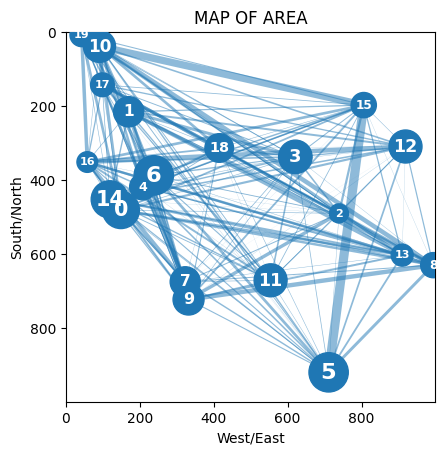

In [ ]:
plot_system(CANVAS, LINES, draw_lines=False)

In [ ]:
def find_shortest_path(adjacency_matrix, weight_matrix, source_node, target_node):
    try:
        # Create a directed graph from the matrices
        G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

        # Add weights to the edges
        for i in range(G.number_of_nodes()):
            for j in range(G.number_of_nodes()):
                if G.has_edge(i, j):
                    G[i][j]['weight'] = weight_matrix[i, j]

        # Find the shortest path from source to target
        shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

        # Calculate the sum of edge weights on the shortest path
        total_weight = sum(G[shortest_path[i]][shortest_path[i + 1]]['weight'] for i in range(len(shortest_path) - 1))

        return shortest_path, total_weight

    except nx.NetworkXNoPath:
        # Return -1 when there is no path between the nodes
        return -1, -1

In [ ]:
def get_min_dist(LINES, DISTANCES):
  MIN_DIST = np.zeros((NUM_STATIONS, NUM_STATIONS))

  for i in range(NUM_STATIONS):
    for j in range(NUM_STATIONS):
      shortest_path, total_weight = find_shortest_path(LINES, DISTANCES, i, j)
      MIN_DIST[i,j] = total_weight

  return MIN_DIST

In [ ]:
MIN_DIST = get_min_dist(LINES, DISTANCES)

MIN_DIST

array([[   0.        ,  266.82765974,  590.06864008,  493.47745643,
          86.31338251,  713.13743416,  129.44883159,  260.59930929,
         858.03612978,  303.4023731 ,  446.78070684,  447.35332792,
         788.97655225,  770.71719846,   41.72529209,  715.7548463 ,
         158.685223  ,  342.6674773 ,  314.61087076,  485.70773105],
       [ 266.82765974,    0.        ,  631.96993599,  467.20980298,
         206.52602742,  888.65403842,  184.95404835,  484.77726844,
         922.60554952,  533.20540132,  193.82982227,  596.14763272,
         754.87548642,  835.55011819,  242.42524621,  636.25466599,
         176.18172436,  101.83319694,  263.87307555,  243.70679104],
       [ 590.06864008,  631.96993599,    0.        ,  193.21749403,
         535.85912328,  430.9106636 ,  511.47824978,  455.28123177,
         290.90376416,  468.9754791 ,  790.06835147,  258.81653734,
         255.26652738,  204.96341137,  621.16342455,  300.56280542,
         695.04100598,  728.49433766,  369.195

In [ ]:
def get_flow_score(LINES, DISTANCES):
    MIN_DIST = get_min_dist(LINES, DISTANCES)

    # Vectorized computation of total distance
    total_dist = np.sum(np.where(MIN_DIST != -1, MIN_DIST * TRIPS, ISLAND_PENALTY * TRIPS))

    return total_dist / np.sum(TRIPS)

In [ ]:
F = get_flow_score(LINES, DISTANCES)

F

432.9659982573134

In [ ]:
BEST_SCORE = F

# **3. Evolution**

## **3.1 Initialization**

In [ ]:
CANVAS_SIZE = 1000
NUM_STATIONS = 20
ISLAND_PENALTY = 5000
TRACK_LIMIT = 8000

NUM_GENERATIONS = 100
POP_SIZE = 100
CROSSOVER_RATE = 0.1
MUTATION_RATE = 0.01

PARENT_SHARE = 0.8
MUTATED_SHARE = 0.0
ELITE_SHARE = 0.2

NUM_PARENTS = int(PARENT_SHARE * POP_SIZE)
NUM_MUTANTS = int(MUTATED_SHARE * POP_SIZE)
NUM_ELITES = int(ELITE_SHARE * POP_SIZE)

TRACK_GEN = 0.53
GEN_PROB = 4
NUM_TO_ELIM = 10
OFF_RATIO = 0.5

In [ ]:
# Initialize the lines probabilistically based on distance
def initialize_lines_probabilistic(NUM_STATIONS, DISTANCES):
    lines = np.zeros((NUM_STATIONS, NUM_STATIONS))
    for i in range(NUM_STATIONS):
        for j in range(i + 1, NUM_STATIONS):
            # Probability of connection decreases with distance
            prob = np.exp(-DISTANCES[i, j] / CANVAS_SIZE * GEN_PROB)
            if np.random.rand() < prob:
                lines[i, j] = 1
                lines[j, i] = 1
    return lines

In [ ]:
LINES_POP = np.array([initialize_lines_probabilistic(NUM_STATIONS, DISTANCES) for _ in range(POP_SIZE)])

In [ ]:
#LINES_POP = np.round(TRACK_GEN * np.random.rand(POP_SIZE, NUM_STATIONS, NUM_STATIONS))

In [ ]:
LINES_POP[0]

array([[0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0.

In [ ]:
# check avg track length
track_lens = np.zeros((POP_SIZE))
for pop in range(POP_SIZE):
  track_len = 0
  track = LINES_POP[pop] * DISTANCES
  for i in range(NUM_STATIONS):
    for j in range(i+1, NUM_STATIONS):
      if track[i,j] > 0 or track[j,i] > 0:
        track_len += DISTANCES[i,j]
  track_lens[pop] = track_len

avg_len = np.sum(track_lens) / POP_SIZE

avg_len

11824.422426626932

In [ ]:
# shorten lines if too much track is used
tasks = np.ones((POP_SIZE))
while np.sum(tasks) != 0:
  for pop in range(POP_SIZE):
    track_len = 0
    track = LINES_POP[pop] * DISTANCES
    for i in range(NUM_STATIONS):
      for j in range(i+1, NUM_STATIONS):
        if track[i,j] > 0 or track[j,i] > 0:
          track_len += DISTANCES[i,j]
    if track_len > TRACK_LIMIT:
      LINES_POP[pop] = np.array([initialize_lines_probabilistic(NUM_STATIONS, DISTANCES)])
    else:
      tasks[pop] = 0

In [ ]:
# make sure all lines are within the track limit after shortening
for pop in range(POP_SIZE):
    track_len = 0
    track = LINES_POP[pop] * DISTANCES
    for i in range(NUM_STATIONS):
      for j in range(i+1, NUM_STATIONS):
        if track[i,j] > 0 or track[j,i] > 0:
          track_len += DISTANCES[i,j]
    print(track_len)

7991.761627371595
7763.327963916401
7081.764734209267
7824.389109254387
7805.029011818288
7972.3211377405305
5853.000042405631
7756.325990499112
6377.31789894119
5093.1863933607465
7270.700551638111
7553.3172063228485
7671.8223175742305
7340.665745713727
7631.4212335402235
7750.497790054002
7943.654194947785
7161.104646864705
7853.609633685707
7673.08276206695
7996.819083946051
6818.952759321087
7810.436780627864
7495.280518247193
7309.1171098218265
7933.822499978987
7707.577406730529
7828.387836057387
7533.49715328943
7627.354499310732
7456.038323301316
7700.074585518139
7828.7232630719545
7628.693815245287
7562.774110697136
6439.4006048908595
7866.745083817231
7671.871402744013
7828.277673424804
6579.083585950825
7932.4625359417905
7729.66036384288
6399.620781369224
7609.309070277137
7269.442690486681
5462.974095261933
7011.614124216879
7979.191315943705
7688.788239172536
7665.038810503112
6336.971995287072
7841.351857253631
6632.360850711437
7871.151233268213
7937.103380820972
7912.

## **3.2 Functions**

In [ ]:
def evaluate(LINES_POP):
    LINES_SCORES = np.zeros((POP_SIZE))
    best_track_len = float('inf')

    for pop in range(POP_SIZE):
      LINES_SCORES[pop] = get_flow_score(LINES_POP[pop], DISTANCES)

      # Calculate track length for the current line
      track = LINES_POP[pop] * DISTANCES
      track_len = 0
      for i in range(NUM_STATIONS):
        for j in range(i+1, NUM_STATIONS):
          if track[i,j] > 0 or track[j,i] > 0:
            track_len += DISTANCES[i,j]

      if track_len < best_track_len:
        best_track_len = track_len

    best_idx = np.argmin(LINES_SCORES)
    best_gen_score = LINES_SCORES[best_idx]
    best_line = LINES_POP[best_idx]
    avg_score = np.average(LINES_SCORES)

    return best_idx, best_gen_score, best_track_len, best_line, avg_score, LINES_SCORES

In [ ]:
def selection(LINES_SCORES):
    # Create shuffled indices
    shuffled_indices = np.random.permutation(len(LINES_SCORES))

    # Select parent indices
    parent_idxs = shuffled_indices[:NUM_PARENTS]

    # Select mutated indices
    mutated_idxs = shuffled_indices[NUM_PARENTS:NUM_PARENTS+NUM_MUTANTS]

    # Select elite indices
    elite_idxs = np.argsort(LINES_SCORES)[:NUM_ELITES]

    return parent_idxs, mutated_idxs, elite_idxs

In [ ]:
def crossover(parents):
  pairs = np.reshape(parents, (NUM_PARENTS // 2, 2, NUM_STATIONS, NUM_STATIONS))
  for pair_idx in range(np.shape(pairs)[0]):
    running = True
    pair = pairs[pair_idx]
    child0 = pair[0, :, :]
    child1 = pair[1, :, :]
    while running:
      # Slice along first axis
      for slice_idx in range(1, NUM_STATIONS):
        if np.random.rand() < CROSSOVER_RATE:
          child0 = np.concatenate((pair[0, :slice_idx, :], pair[1, slice_idx:, :]), axis=0)
          child1 = np.concatenate((pair[1, :slice_idx, :], pair[0, slice_idx:, :]), axis=0)

      # Slice along second axis
      for slice_idx in range(1, NUM_STATIONS):
        if np.random.rand() < CROSSOVER_RATE:
          temp0 = np.concatenate((child0[:, :slice_idx], pair[1, :, slice_idx:]), axis=1)
          temp1 = np.concatenate((child1[:, :slice_idx], pair[0, :, slice_idx:]), axis=1)
          # Update children
          child0 = temp0
          child1 = temp1

      # Check if track limits are satisfied
      track_len_1 = 0
      for i in range(NUM_STATIONS):
        for j in range(i+1, NUM_STATIONS):
          if child0[i,j] > 0 or child0[j,i] > 0:
            track_len_1 += DISTANCES[i,j]

      track_len_2 = 0
      for i in range(NUM_STATIONS):
        for j in range(i+1, NUM_STATIONS):
          if child1[i,j] > 0 or child1[j,i] > 0:
            track_len_2 += DISTANCES[i,j]

      if track_len_1 < TRACK_LIMIT and track_len_2 < TRACK_LIMIT:
        temp = np.array((child0, child1))
        pairs[pair_idx] = temp
        running = False
  pairs = np.reshape(pairs, (NUM_PARENTS, NUM_STATIONS, NUM_STATIONS))
  return pairs

In [ ]:
def mutation(mutants):
  for mutant_idx in range(NUM_MUTANTS):
    mutated = mutants[mutant_idx]
    running = True
    while running:
      # Mutate
      for i in range(NUM_STATIONS):
        for j in range(NUM_STATIONS):
          if np.random.rand() < MUTATION_RATE:
            if mutated[i, j] == 1:
              mutated[i, j] = 0
            else:
              mutated[i, j] = 1
      # Check lengths
      track_len = 0
      for i in range(NUM_STATIONS):
        for j in range(i+1, NUM_STATIONS):
          if mutated[i, j] > 0 or mutated[j, i] > 0:
            track_len += DISTANCES[i,j]
      # Loop end condition
      if track_len < TRACK_LIMIT:
        mutants[mutant_idx] = mutated
        running = False
      else:
        z_idxs = np.random.randint(0, NUM_STATIONS, size=(20, 2), dtype=np.int32)
        for idx in range(NUM_TO_ELIM):
          i = z_idxs[idx][0]
          j = z_idxs[idx][1]
          mutated[i, j] = 0
          mutated[j, i] = 0
  return mutants

# **4. Results**

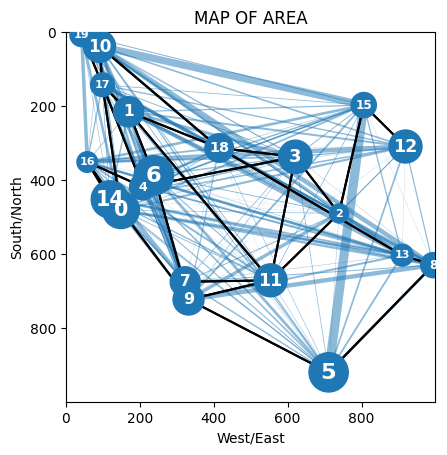

GENERATION #0
Best Score: 572.8627143503729
Track Length: 5093.1863933607465
Average Score: 1273.504714552394
SCORE TO BEAT: 432.9659982573134


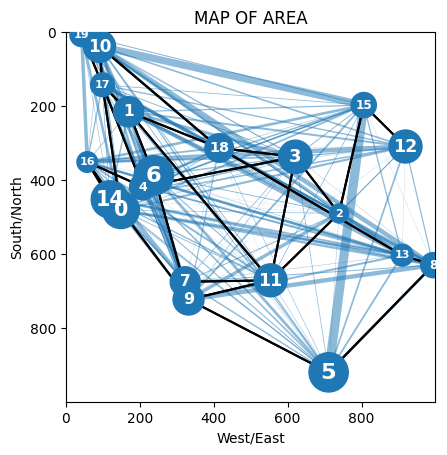

GENERATION #1
Best Score: 572.8627143503729
Track Length: 5462.974095261933
Average Score: 1154.693094507018
SCORE TO BEAT: 432.9659982573134


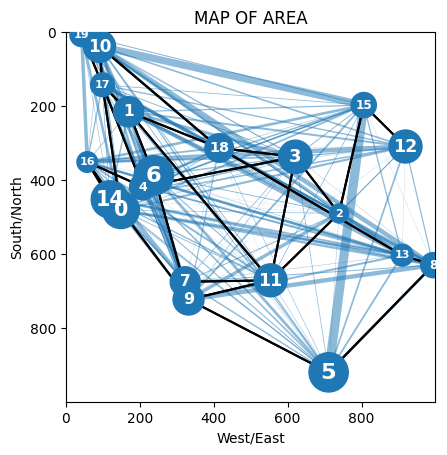

GENERATION #2
Best Score: 572.8627143503729
Track Length: 5504.699387351983
Average Score: 1064.174924492423
SCORE TO BEAT: 432.9659982573134


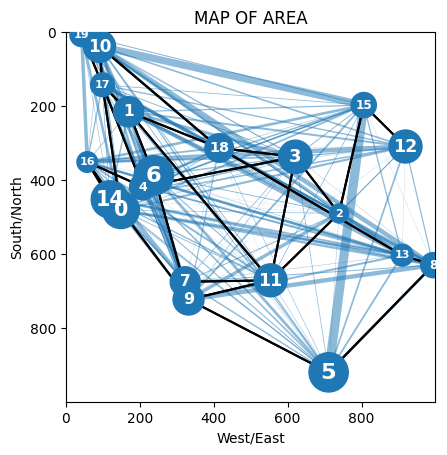

GENERATION #3
Best Score: 572.8627143503729
Track Length: 6343.832429298395
Average Score: 989.3703412128203
SCORE TO BEAT: 432.9659982573134


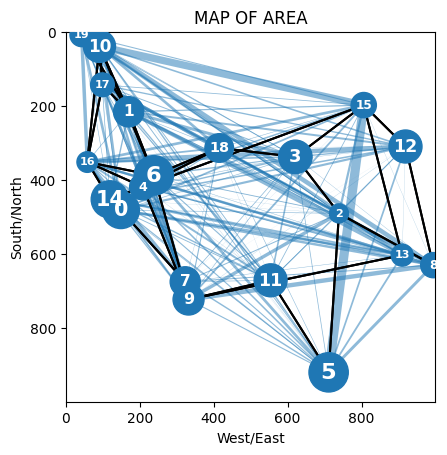

GENERATION #4
Best Score: 557.8022909087829
Track Length: 6490.016385268639
Average Score: 908.234215497586
SCORE TO BEAT: 432.9659982573134


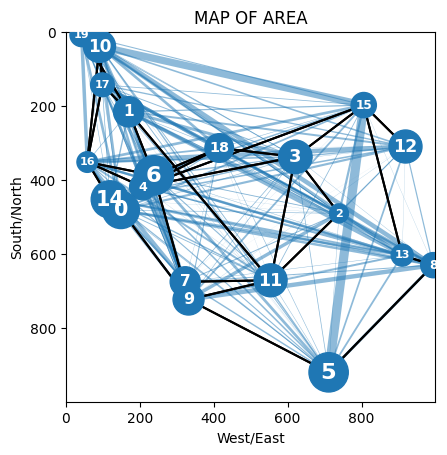

GENERATION #5
Best Score: 543.8157851228707
Track Length: 7437.513726785736
Average Score: 832.4316375357455
SCORE TO BEAT: 432.9659982573134


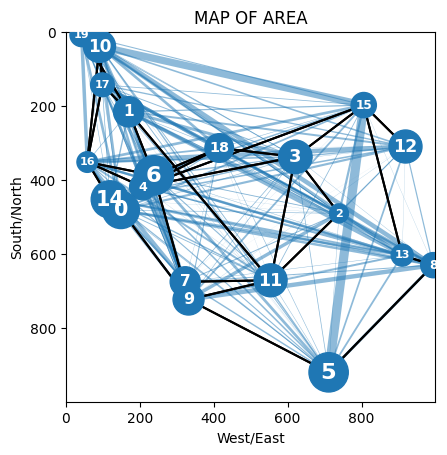

GENERATION #6
Best Score: 543.8157851228707
Track Length: 7517.394315009536
Average Score: 770.4929272259001
SCORE TO BEAT: 432.9659982573134


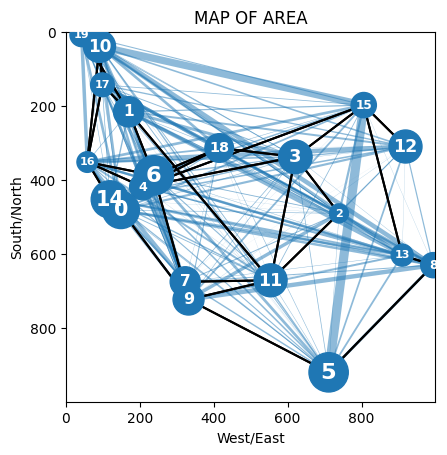

GENERATION #7
Best Score: 543.8157851228707
Track Length: 7560.109931671244
Average Score: 737.0686226266284
SCORE TO BEAT: 432.9659982573134


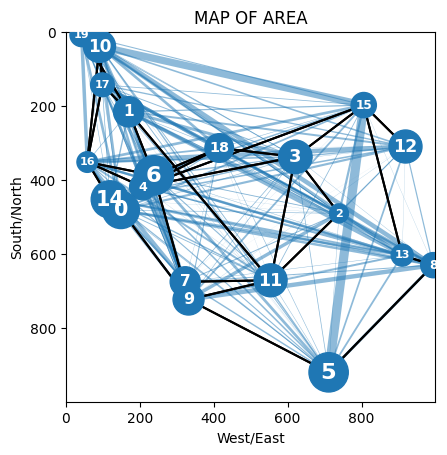

GENERATION #8
Best Score: 543.8157851228707
Track Length: 7572.012426666407
Average Score: 731.8392650156243
SCORE TO BEAT: 432.9659982573134


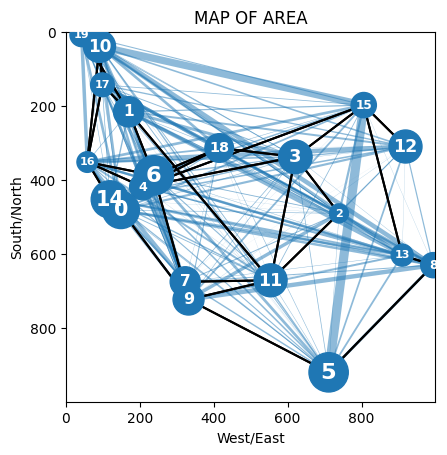

GENERATION #9
Best Score: 543.8157851228707
Track Length: 7572.012426666407
Average Score: 699.0297626181605
SCORE TO BEAT: 432.9659982573134


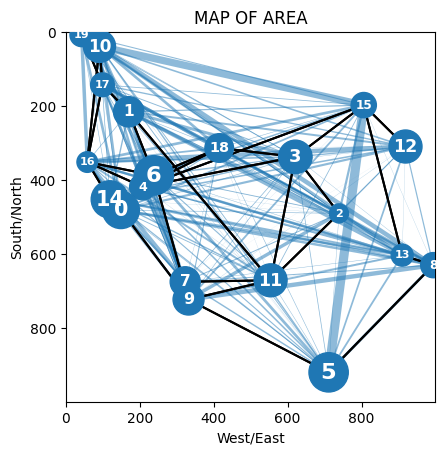

GENERATION #10
Best Score: 533.4847404587582
Track Length: 7626.997324966404
Average Score: 673.2451083319509
SCORE TO BEAT: 432.9659982573134


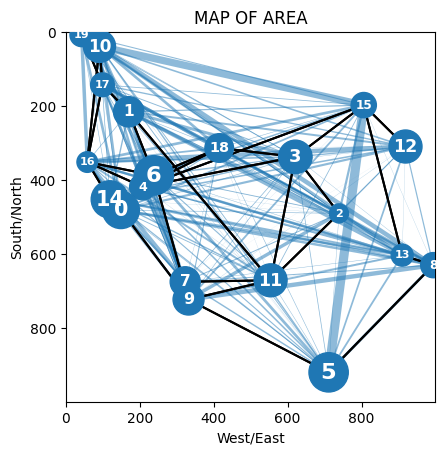

GENERATION #11
Best Score: 533.4847404587582
Track Length: 7632.735661109356
Average Score: 652.5929334407517
SCORE TO BEAT: 432.9659982573134


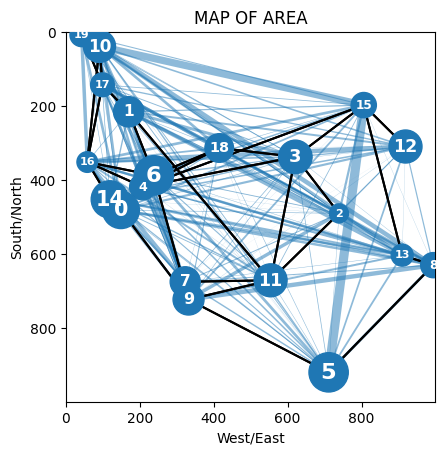

GENERATION #12
Best Score: 533.4847404587582
Track Length: 7632.735661109356
Average Score: 624.0002606910676
SCORE TO BEAT: 432.9659982573134


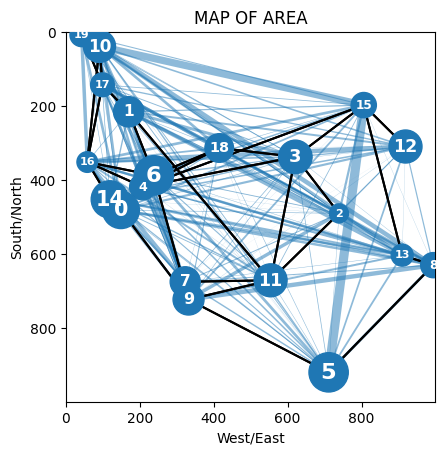

GENERATION #13
Best Score: 533.4847404587582
Track Length: 7679.756880082099
Average Score: 600.5731726457108
SCORE TO BEAT: 432.9659982573134


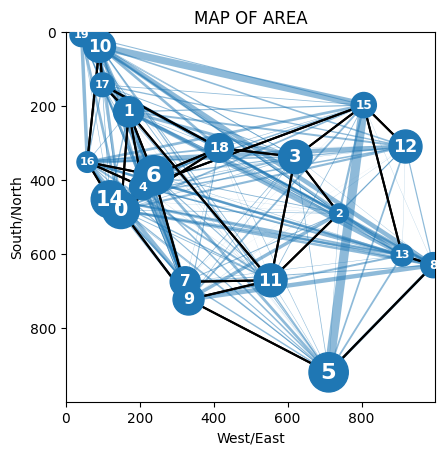

GENERATION #14
Best Score: 527.9874052425714
Track Length: 7679.756880082099
Average Score: 589.2992305851378
SCORE TO BEAT: 432.9659982573134


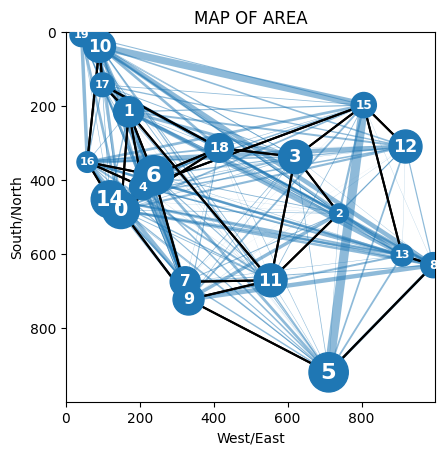

GENERATION #15
Best Score: 527.9874052425714
Track Length: 7709.489710288209
Average Score: 572.6317704765856
SCORE TO BEAT: 432.9659982573134


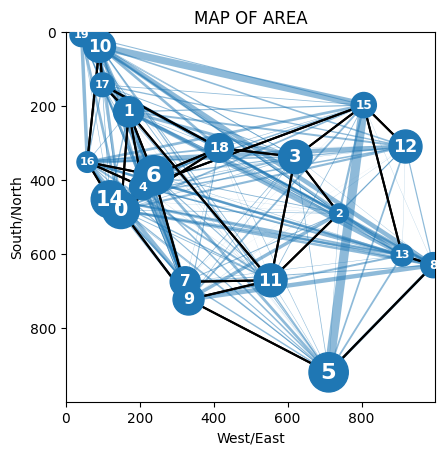

GENERATION #16
Best Score: 527.9874052425714
Track Length: 7795.446472220717
Average Score: 570.2324419354443
SCORE TO BEAT: 432.9659982573134


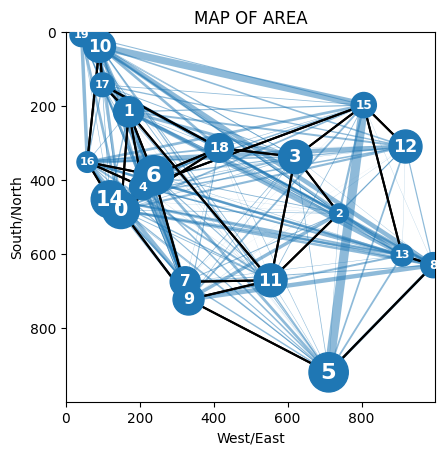

GENERATION #17
Best Score: 527.9874052425714
Track Length: 7795.446472220717
Average Score: 545.5803943872655
SCORE TO BEAT: 432.9659982573134


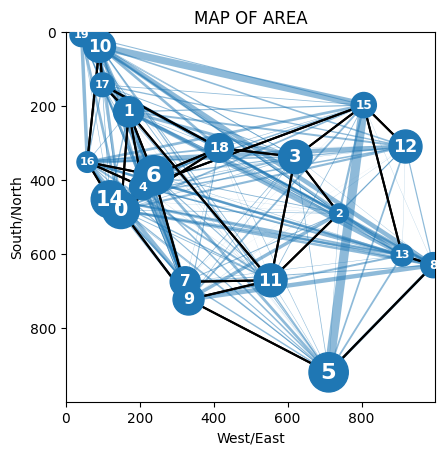

GENERATION #18
Best Score: 527.9874052425714
Track Length: 7795.446472220717
Average Score: 542.8949006806957
SCORE TO BEAT: 432.9659982573134


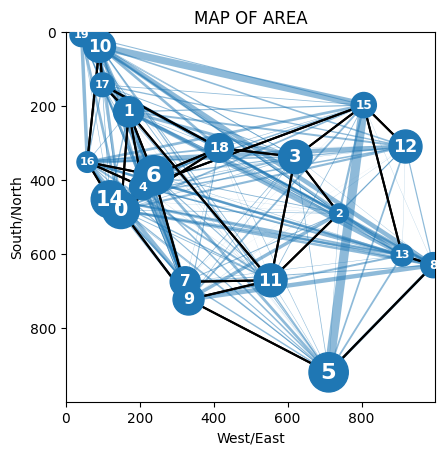

GENERATION #19
Best Score: 527.9874052425714
Track Length: 7795.446472220717
Average Score: 540.2669698309127
SCORE TO BEAT: 432.9659982573134


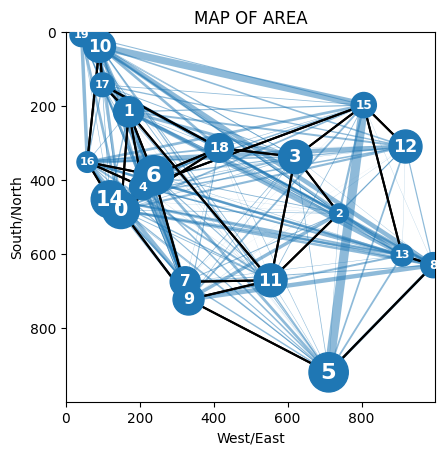

GENERATION #20
Best Score: 527.9874052425714
Track Length: 7795.446472220717
Average Score: 538.8173218637927
SCORE TO BEAT: 432.9659982573134


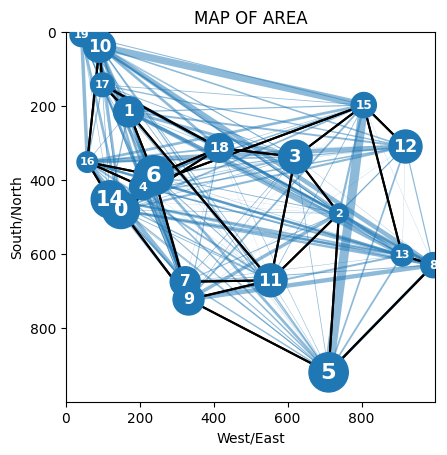

GENERATION #21
Best Score: 527.7871047548261
Track Length: 7847.93200899688
Average Score: 541.5087357625058
SCORE TO BEAT: 432.9659982573134


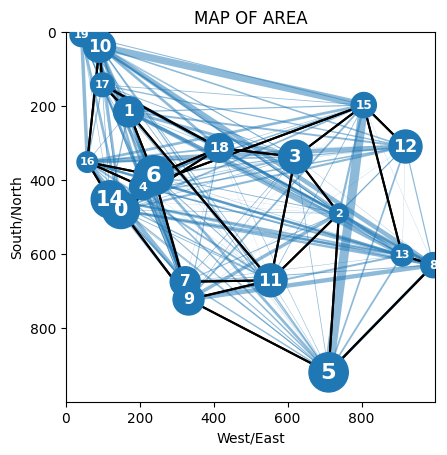

GENERATION #22
Best Score: 527.7871047548261
Track Length: 7795.446472220717
Average Score: 539.9188190941119
SCORE TO BEAT: 432.9659982573134


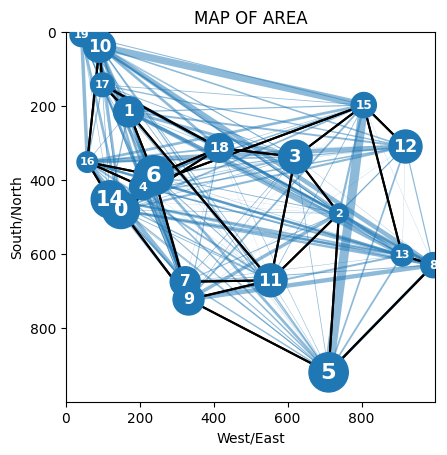

GENERATION #23
Best Score: 527.7871047548261
Track Length: 7795.446472220717
Average Score: 537.3895382277184
SCORE TO BEAT: 432.9659982573134


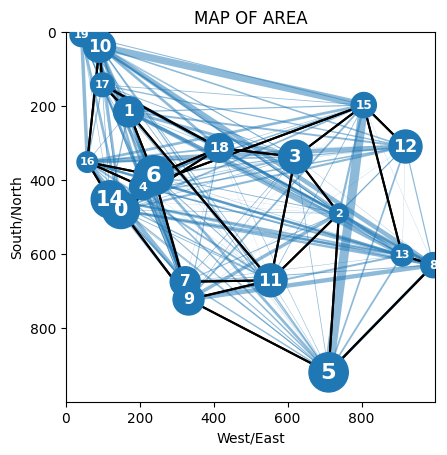

GENERATION #24
Best Score: 527.7871047548261
Track Length: 7858.1261899678375
Average Score: 535.3983056171351
SCORE TO BEAT: 432.9659982573134


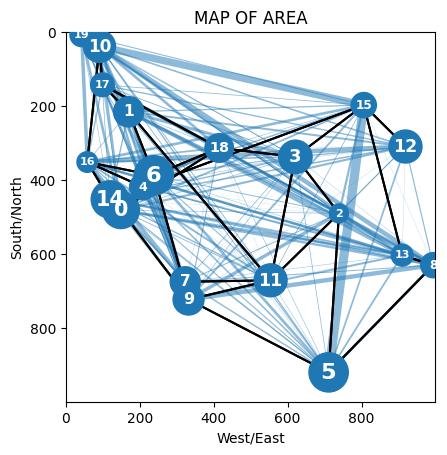

GENERATION #25
Best Score: 525.4218592635528
Track Length: 7858.1261899678375
Average Score: 530.4029185200857
SCORE TO BEAT: 432.9659982573134


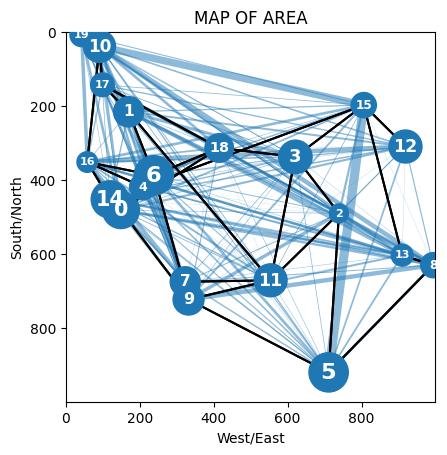

GENERATION #26
Best Score: 525.4218592635528
Track Length: 7858.1261899678375
Average Score: 534.1537115265724
SCORE TO BEAT: 432.9659982573134


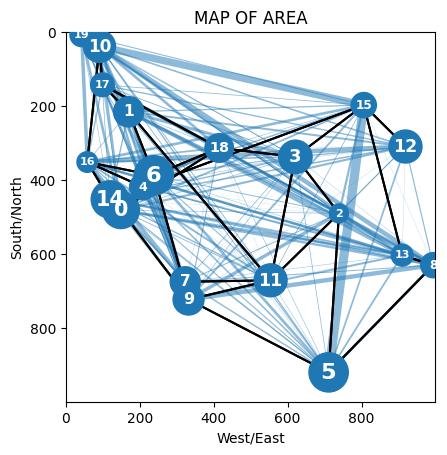

GENERATION #27
Best Score: 525.4218592635528
Track Length: 7858.1261899678375
Average Score: 529.2871491165358
SCORE TO BEAT: 432.9659982573134


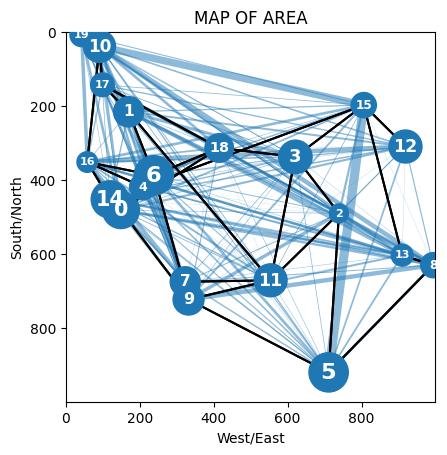

GENERATION #28
Best Score: 525.4218592635528
Track Length: 7858.1261899678375
Average Score: 528.7327802087198
SCORE TO BEAT: 432.9659982573134


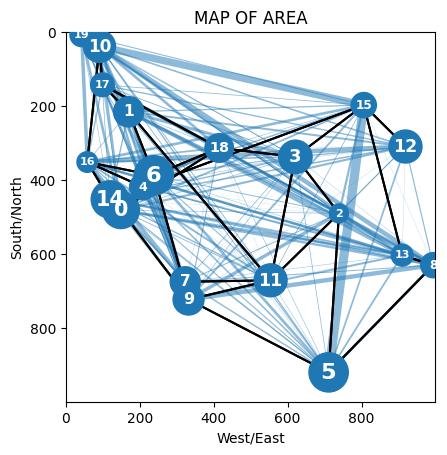

GENERATION #29
Best Score: 525.4218592635528
Track Length: 7858.1261899678375
Average Score: 528.3021000684982
SCORE TO BEAT: 432.9659982573134


KeyboardInterrupt: ignored

In [ ]:
for gen in range(NUM_GENERATIONS):
  # Evaluate population
  best_idx, best_gen_score, best_track_len, best_line, avg_score, LINES_SCORES = evaluate(LINES_POP)

  # Display results
  plot_system(CANVAS, best_line)
  print(f'\033[1mGENERATION #{gen}\033[0m')
  print(f'Best Score: {best_gen_score}')
  print(f'Track Length: {best_track_len}')
  print(f'Average Score: {avg_score}')
  print(f'SCORE TO BEAT: {BEST_SCORE}')

  # Selection (parents and elites)
  parent_idxs, mutated_idxs, elite_idxs = selection(LINES_SCORES)
  parents = LINES_POP[parent_idxs]
  mutants = LINES_POP[mutated_idxs]
  elites = LINES_POP[elite_idxs]

  # Crossover
  children = crossover(parents)

  # Mutation
  mutated = mutation(mutants)

  # Next gen
  del LINES_POP
  LINES_POP = np.concatenate((children, mutants), axis=0)
  LINES_POP = np.concatenate((LINES_POP, elites), axis=0)